In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
applicant_df=pd.read_csv('applicant.csv')

applicant_df['Has_been_employed_for_at_least'].fillna('0 year', inplace=True)
applicant_df['Has_been_employed_for_at_most'].fillna('7 years', inplace=True)

applicant_df['Telephone_Registered_under_applicants_name']=applicant_df['Telephone'].apply(lambda x: 1 if pd.notna(x) else 0)
applicant_df['Savings_account_balance']=applicant_df['Savings_account_balance'].apply(lambda x: x if pd.notna(x) else 'unknown')

applicant_df.drop('Telephone', axis=1, inplace=True)


loan_df=pd.read_csv('loan.csv')

loan_df['Property']=loan_df['Property'].apply(lambda x: x if pd.notna(x) else 'none')
loan_df['Other_EMI_plans']=loan_df['Other_EMI_plans'].apply(lambda x: x if pd.notna(x) else 'none')

loan_df.drop('loan_application_id', axis=1, inplace=True)

merged_df=pd.merge(applicant_df,loan_df,on='applicant_id')
merged_df.drop('applicant_id', axis=1, inplace=True)
merged_df.drop('Balance_in_existing_bank_account_(lower_limit_of_bucket)', axis=1, inplace=True)
merged_df.drop('Balance_in_existing_bank_account_(upper_limit_of_bucket)', axis=1, inplace=True)

print(merged_df.shape)
merged_df.dropna(subset=['Purpose'], inplace=True)
print(merged_df.shape)

(1000, 23)
(988, 23)


In [21]:
print("Missing values in applicant dataset:")
print(merged_df.isnull().sum())

print(merged_df)

Missing values in applicant dataset:
Primary_applicant_age_in_years                 0
Gender                                         0
Marital_status                                 0
Number_of_dependents                           0
Housing                                        0
Years_at_current_residence                     0
Employment_status                              0
Has_been_employed_for_at_least                 0
Has_been_employed_for_at_most                  0
Foreign_worker                                 0
Savings_account_balance                        0
Telephone_Registered_under_applicants_name     0
Months_loan_taken_for                          0
Purpose                                        0
Principal_loan_amount                          0
EMI_rate_in_percentage_of_disposable_income    0
Property                                       0
Has_coapplicant                                0
Has_guarantor                                  0
Other_EMI_plans                 

In [22]:
#Personal
print(merged_df[['Primary_applicant_age_in_years', 'Gender',
                 'Marital_status', 'Employment_status']].describe(include='all'))
#Financial
print(merged_df[['Savings_account_balance']].describe(include='all'))

#Loan
print(merged_df[['Principal_loan_amount', 'EMI_rate_in_percentage_of_disposable_income',
                 'Purpose', 'Property', 'Loan_history']].describe(include='all'))

        Primary_applicant_age_in_years Gender Marital_status  \
count                       988.000000    988            988   
unique                             NaN      2              4   
top                                NaN   male         single   
freq                               NaN    681            540   
mean                         35.492915    NaN            NaN   
std                          11.371455    NaN            NaN   
min                          19.000000    NaN            NaN   
25%                          27.000000    NaN            NaN   
50%                          33.000000    NaN            NaN   
75%                          42.000000    NaN            NaN   
max                          75.000000    NaN            NaN   

                  Employment_status  
count                           988  
unique                            4  
top     skilled employee / official  
freq                            629  
mean                            NaN  
std

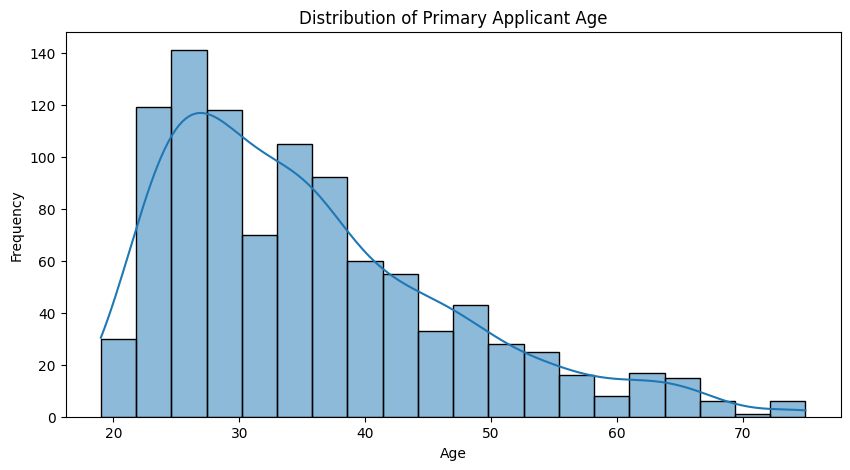

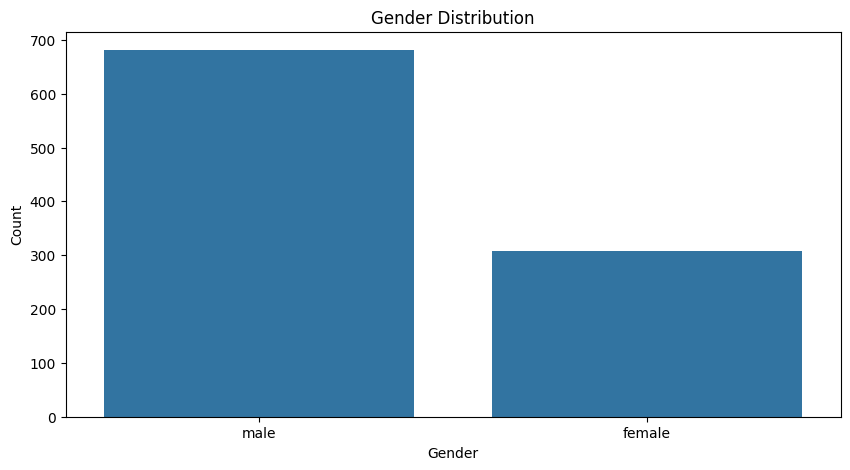

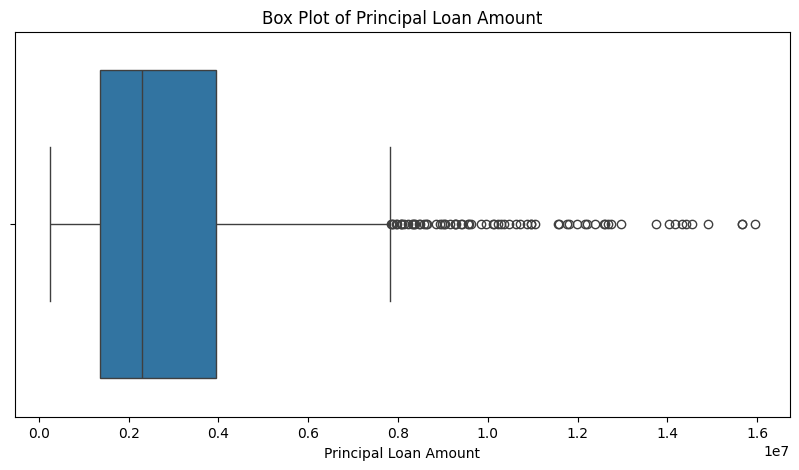

In [23]:
# Histogram for Age
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Primary_applicant_age_in_years'], bins=20, kde=True)
plt.title('Distribution of Primary Applicant Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bar chart for Gender
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_df, x='Gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Box plot for Loan Amount
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='Principal_loan_amount')
plt.title('Box Plot of Principal Loan Amount')
plt.xlabel('Principal Loan Amount')
plt.show()

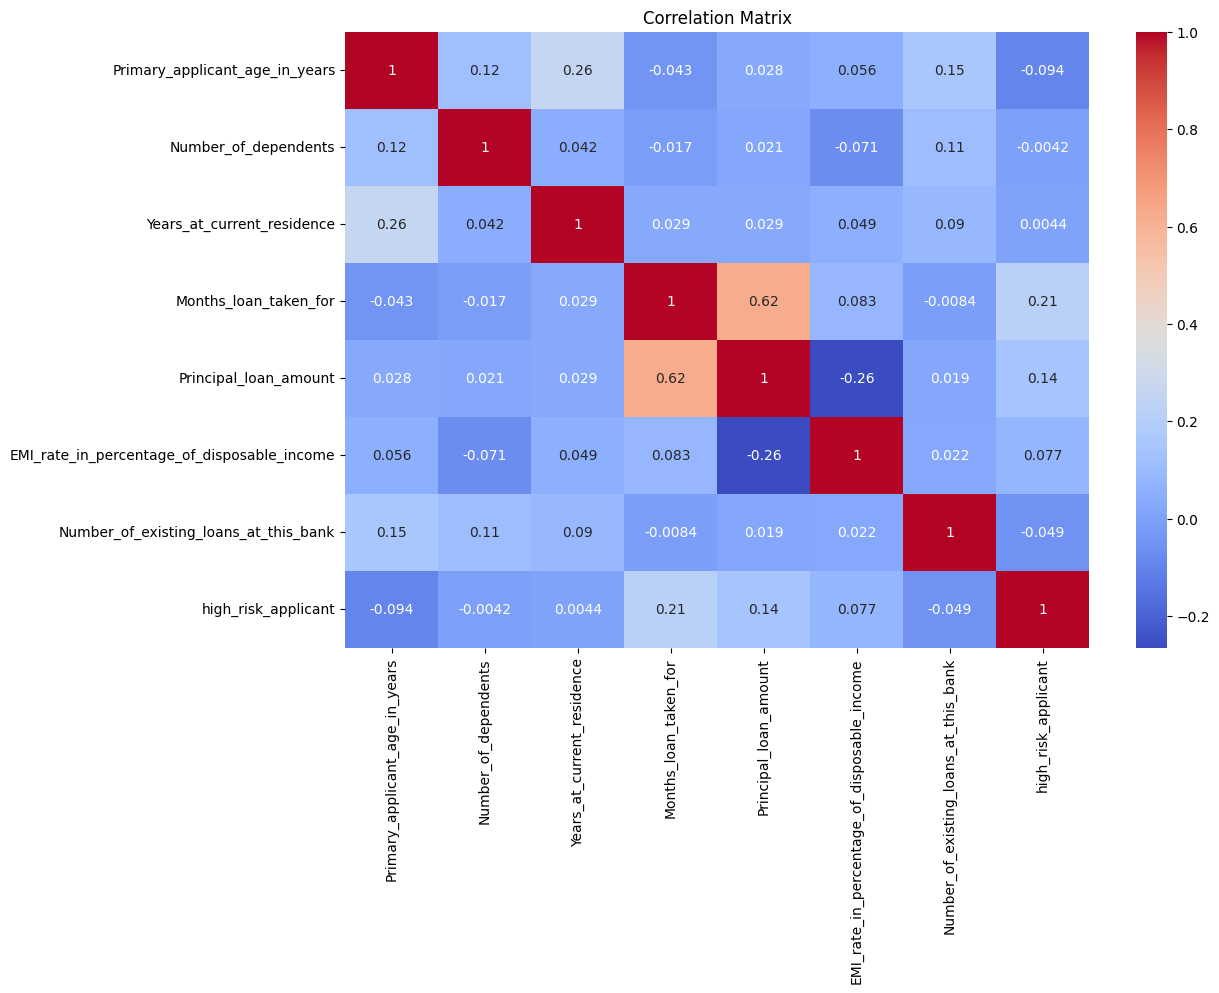

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[['Primary_applicant_age_in_years','Number_of_dependents',
                       'Years_at_current_residence','Months_loan_taken_for','Principal_loan_amount',
                       'EMI_rate_in_percentage_of_disposable_income','Number_of_existing_loans_at_this_bank',
                       'high_risk_applicant']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Feature and target extraction
# merged_df=merged_df.drop('applicant_id', axis=1, inplace=True)
# merged_df=merged_df.drop('loan_application_id', axis=1, inplace=True)
X = merged_df.drop('high_risk_applicant', axis=1)
y = merged_df['high_risk_applicant']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessing pipeline for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Logistic Regression model
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression())])

# Random Forest model
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier())])

# Train Logistic Regression model
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

y_pred_prob_logreg = logreg.predict_proba(X_test)[:, 1]
# Adjust the threshold to increase recall for high-risk prediction
threshold = 0.3
y_pred_logreg = (y_pred_prob_logreg >= threshold).astype(int)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("Recall for High-Risk Predictions:")
print(recall_score(y_test, y_pred_logreg))

# Train Random Forest model
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Hyperparameter tuning for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_features': ['log2', 'sqrt'],
    'classifier__max_depth': [10, 20, 30, 40]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {grid_search.best_params_}")

# Save the model
# import joblib
# joblib.dump(grid_search.best_estimator_, 'best_rf_model.pkl')


Logistic Regression Confusion Matrix:
[[127  13]
 [ 34  24]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       140
           1       0.65      0.41      0.51        58

    accuracy                           0.76       198
   macro avg       0.72      0.66      0.67       198
weighted avg       0.75      0.76      0.74       198

Logistic Regression Confusion Matrix:
[[101  39]
 [ 17  41]]
Recall for High-Risk Predictions:
0.7068965517241379
Random Forest Confusion Matrix:
[[127  13]
 [ 43  15]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       140
           1       0.54      0.26      0.35        58

    accuracy                           0.72       198
   macro avg       0.64      0.58      0.58       198
weighted avg       0.69      0.72      0.68       198

Best parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__n_

In [25]:
best_rf = grid_search.best_estimator_
print(f"Best parameters for Random Forest: {grid_search.best_params_}")

# Fit the best model and predict
best_rf.fit(X_train, y_train)
y_pred_prob_rf = best_rf.predict(X_test)


print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_prob_rf))
print("Recall for High-Risk Predictions (Random Forest):")

print(classification_report(y_test, y_pred_prob_rf))

Best parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}
Random Forest Confusion Matrix:
[[126  14]
 [ 40  18]]
Recall for High-Risk Predictions (Random Forest):
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       140
           1       0.56      0.31      0.40        58

    accuracy                           0.73       198
   macro avg       0.66      0.61      0.61       198
weighted avg       0.70      0.73      0.70       198

